In [3]:
import pandas as pd

In [4]:

df = pd.read_csv('recons-sab-bma.csv')


In [5]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCTCCGTTGTATCTA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGGG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAAATGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGCTGAGCGCCATTTTGTTTA...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...


In [6]:
from tqdm import tqdm


In [7]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [8]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [9]:
import difflib


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [11]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 90035.70it/s]


[21, 88, 99, 104, 122, 138, 183, 186, 202, 208, 227, 257, 268, 302, 316, 349, 363, 387, 384, 427, 462, 478, 501, 524, 579, 602, 591, 619, 640, 694, 695, 718, 730, 797, 822, 830, 873, 888, 912, 965, 1003, 989, 1047, 1042, 1089, 1072, 1090, 1149, 1181, 1177, 1245, 1199, 1265, 1330, 1346, 2073, 2018, 2001, 1974, 1980, 1921, 1889, 1898, 1854, 1850, 1771, 1744, 1784, 1746, 1701, 1682, 1663, 1606, 1603, 1589, 1608, 1555, 1525, 1514, 1486, 1500, 1444, 1427, 1397, 1398, 1379, 1324, 1333, 1310, 1269, 1256, 1245, 1250, 1227, 1212, 1186, 1155, 1145, 1121, 1037, 1072, 1074, 1088, 1050, 1016, 1034, 1078, 1064, 953, 743]


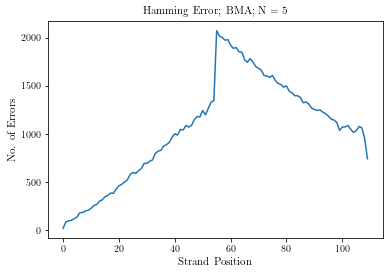

In [12]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [13]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:06<00:00, 1558.37it/s]


In [14]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


GAT ->  6
TTG ->  6
 -> GAG 6
G -> AT 6
CAT ->  6
T -> GG 6
 -> TGT 6
GC -> AA 6
 -> AAT 6
 -> ACA 6
TGT ->  6
C -> GA 6
TCG ->  6
TAC ->  6
TCC ->  7
GT -> AA 7
GTA ->  7
 -> CCC 7
TGG ->  7
TC -> G 7
T -> CG 7
CTT ->  7
CGG ->  7
CGT ->  7
GTC ->  8
 -> CAA 8
GT -> AC 8
AA ->  8
 -> AAC 8
ATT ->  8
TAT ->  8
G -> CA 8
 -> ACG 9
TG -> AC 9
T -> GA 10
T -> CC 10
C -> AA 10
TG -> C 11
GC -> A 11
G -> CC 11
T -> CA 12
T -> GC 12
TGC ->  13
CT -> A 13
G -> AA 13
TT -> A 13
CG -> A 13
G -> AC 14
GT -> C 15
T -> AG 16
TC -> A 16
GT -> A 17
TG -> A 17
T -> AC 18
T -> AA 19
CC ->  20
AC ->  21
AG ->  31
 -> TA 32
CA ->  34
 -> GT 34
 -> GG 35
GG ->  37
GA ->  37
 -> TG 37
GC ->  39
 -> GC 39
 -> TT 39
TA ->  39
 -> CT 40
 -> CG 40
CG ->  41
 -> AC 41
 -> TC 41
TT ->  46
 -> AT 49
AT ->  50
 -> GA 50
 -> CC 56
CT ->  57
A -> T 60
 -> AG 60
 -> CA 65
C -> T 66
 -> AA 66
TC ->  68
GT ->  69
A -> G 74
G -> T 75
TG ->  78
C -> G 80
A -> C 87
G -> C 300
G -> A 319
T -> G 354
T -> A 397
C -> A 401
T

C ->  @ 49 6
 -> C @ 33 6
 -> A @ 89 6
C ->  @ 38 6
 -> C @ 32 6
G ->  @ 4 6
 -> A @ 88 6
 -> A @ 87 6
 -> A @ 41 6
C ->  @ 40 6
C ->  @ 36 6
C ->  @ 9 6
G ->  @ 43 6
 -> A @ 84 6
C ->  @ 92 6
 -> A @ 73 6
C -> A @ 88 6
C -> A @ 81 6
 -> A @ 74 6
 -> A @ 30 6
 -> C @ 64 6
A ->  @ 94 6
C ->  @ 12 6
C -> A @ 67 6
 -> A @ 92 6
C ->  @ 93 6
C ->  @ 24 6
C ->  @ 72 6
C ->  @ 69 6
C ->  @ 13 6
 -> A @ 46 6
C ->  @ 63 6
C -> A @ 32 6
G ->  @ 20 6
C ->  @ 59 6
C ->  @ 20 6
G ->  @ 3 6
C ->  @ 50 6
 -> A @ 35 6
 -> C @ 20 6
 -> AT @ 56 6
 -> A @ 34 6
C ->  @ 34 6
C -> A @ 57 6
G ->  @ 15 6
 -> C @ 103 6
C ->  @ 17 6
 -> C @ 30 6
C ->  @ 91 6
T -> G @ 65 6
T -> C @ 66 6
T -> A @ 50 6
T -> A @ 53 6
T -> C @ 95 6
T -> A @ 55 6
T -> C @ 91 6
 -> GAG @ 55 6
T -> C @ 79 6
T ->  @ 7 6
A ->  @ 105 6
T -> C @ 73 6
T -> C @ 71 6
T -> C @ 68 6
T ->  @ 95 6
T -> C @ 63 6
G ->  @ 64 6
T -> C @ 61 6
G ->  @ 72 6
T ->  @ 75 6
G -> A @ 55 6
 -> CA @ 56 6
A ->  @ 59 6
T -> G @ 70 6
T -> G @ 56 6
T ->  @ 9 6
T -

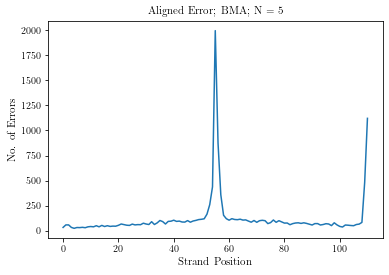

In [15]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [16]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [17]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [18]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 20, 10, 6, 3, 7, 8, 6, 5, 6, 6, 5, 9, 4, 10, 7, 6, 6, 5, 5, 7, 11, 6, 5, 4, 6, 10, 8, 9, 13, 7, 10, 9, 6, 14, 13, 10, 4, 13, 13, 13, 11, 9, 10, 11, 14, 9, 9, 7, 11, 8, 15, 11, 10, 23, 68, 118, 41, 19, 7, 5, 8, 5, 10, 14, 12, 13, 7, 10, 11, 11, 14, 12, 13, 9, 6, 9, 10, 11, 8, 6, 10, 11, 3, 10, 10, 7, 13, 7, 7, 10, 5, 8, 8, 6, 6, 8, 6, 15, 9, 7, 2, 9, 13, 11, 4, 5, 7, 14, 39, 273]
[20, 7, 0, 2, 2, 4, 4, 3, 3, 2, 2, 1, 4, 5, 4, 2, 4, 3, 5, 2, 5, 7, 11, 1, 8, 4, 4, 3, 5, 4, 6, 3, 5, 9, 6, 6, 7, 5, 8, 12, 12, 6, 11, 4, 9, 2, 6, 14, 7, 5, 9, 12, 25, 32, 43, 320, 62, 17, 8, 3, 5, 7, 10, 11, 8, 5, 2, 8, 5, 13, 4, 10, 10, 6, 6, 4, 7, 7, 10, 4, 5, 5, 5, 3, 6, 10, 3, 6, 6, 6, 5, 5, 6, 4, 7, 7, 4, 1, 4, 8, 4, 3, 8, 2, 5, 1, 5, 8, 21, 115, 45]
[7, 5, 0, 3, 3, 3, 1, 2, 2, 3, 3, 4, 2, 2, 2, 1, 4, 4, 3, 3, 6, 3, 4, 7, 5, 2, 1, 2, 1, 4, 6, 2, 6, 6, 1, 5, 2, 5, 2, 3, 9, 3, 5, 4, 1, 7, 5, 5, 10, 3, 4, 8, 19, 41, 48, 317, 49, 23, 14, 8, 8, 9, 9, 4, 6, 7, 8, 3, 4, 9, 4, 3, 5, 3, 6, 3, 9, 5, 6, 5, 3, 5,

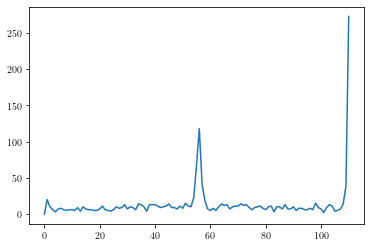

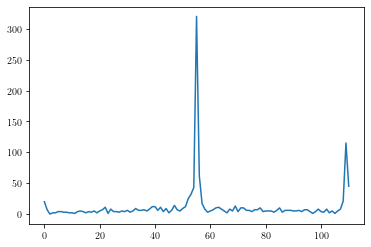

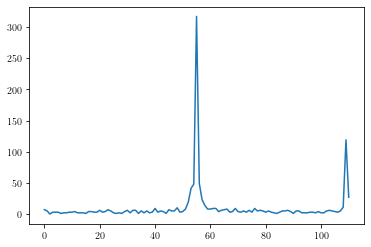

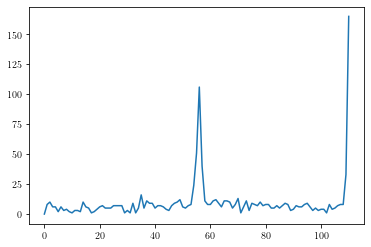

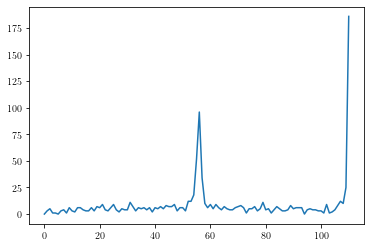

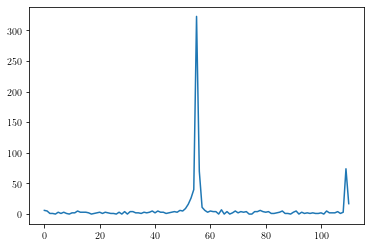

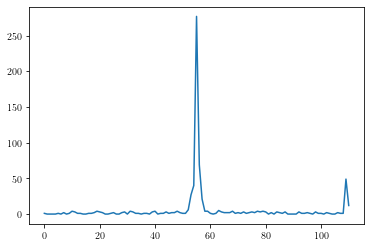

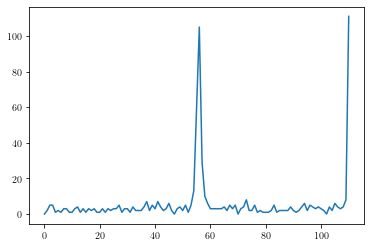

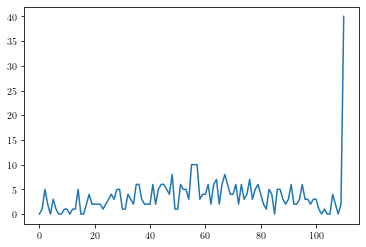

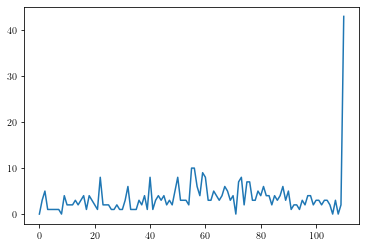

In [19]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [20]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)